In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

import tensorflow as tf
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import string

In [2]:
# Setup some variables

tknzr = TweetTokenizer()
stemmer = PorterStemmer()
nltk.download('punkt')

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


----------------------------------------------------------------------

## Declaring some functions

In [3]:
# função de limpar texto
def cleanText(words, stem=False):
  """
    Esta função recebe um text e retorna o mesmo, já tratado com stopwords & punctuation
  """
  newWords = list()
  pontuacao = string,
  for word in words:
    word = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', word)
    words = re.sub("(@[A-Za-z0-9_]+)","", word)
    if len(word) > 0 and words not in string.punctuation and word.lower() not in stopwords and word.lower != "<br />":
      if stem:
        word = stemmer.stem(word.lower())
        newWords.append(word)
      else:
        newWords.append(word.lower())

  return newWords

In [4]:
# confusion matrix daora
def plot_conf_mat(y_test, y_preds, norm="false"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds, normalize=norm),
                    annot=True,
                    cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

In [5]:
def plot_loss_and_accuracy(losses, accs):

  fig, ax_tuple = plt.subplots(1, 2, figsize=(16,6))
  fig.suptitle('Loss and accuracy')

  for i, (y_label, y_values) in enumerate(zip(['BCE loss','Accuracy'],[losses, accs])):
    ax_tuple[i].plot(range(len(y_values)),  y_values, label='train')
    ax_tuple[i].set_xlabel('epochs')
    ax_tuple[i].set_ylabel(y_label)
    ax_tuple[i].legend()

In [6]:
def label2Embedding(sentence):
  for word in sentence: 
    if word in modelo.vocab:
      embed = modelo.get_vector(word)

      if embed is not None:
        # print(embed)
        return embed
    # else:
    #   print("This word is not in the vocabuylary: ", word, "\n")
    #   return 0
    #   

-------------------------------------------------------------------------------

### Importando o arquivo do GloVE de 50 dimensões e criando a variável *modelo* que será por onde iremos interagir com o *word embedding* já treinado

In [7]:
cwd = os.getcwd()
cwd

'c:\\Users\\carlo\\Projetos\\2020_INF425_NLP_SeReS\\eda\\exercises'

In [8]:
glove_file = datapath(cwd+'/../data/glove.6B.50d.txt')
tmp_file   = get_tmpfile(cwd+"/../data/glove.6B.50d_word2vec.txt")
_          = glove2word2vec(glove_file, tmp_file)

filename_txt = cwd+"/../data/glove.6B.50d_word2vec.txt"
modelo = KeyedVectors.load_word2vec_format(filename_txt)

### Lendo o dataset

In [9]:
df = pd.read_csv("../data/data.csv", encoding = "ISO-8859-1")
df.tail()

,Sl no,Tweets,Search key,Feeling
10012,10016,"Tweet #85: @Matteo tweeted ""@GameSpot @Frannkc...",irritating,angry
10013,10017,Tweet #86: @ðð§ð¢ð¬ð­ð¨ð§ tweet...,irritating,angry
10014,10018,"Tweet #87: @Chowkidar Ricky Sharma tweeted ""@M...",irritating,angry
10015,10019,"Tweet #88: @Katoe.EXE tweeted ""u know what i h...",irritating,angry
10016,10019,"Tweet #88: @Katoe.EXE tweeted ""u know what i h...",irritating,angry


### Copiando o dataset e fazendo transformações necessárias

In [10]:
dataset = df.copy()

dataset = dataset.drop(columns=["Sl no", "Search key"])
dataset.head()

,Tweets,Feeling
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy
1,"#2: @è®è± &ã¯ãã ed ""RT @ninjaryugo: ï¼...",happy
2,"#3: @Ris â¡ ed ""Happy birthday to one smokin...",happy
3,#4: @ìì [ìì¯´ì¬ëë¡ë´] jwinnie is t...,happy
4,"#5: @Madhurima wth u vcâ¥ ed ""Good morning d...",happy


### Criando uma categoria com o *pd.Categorical* para cada emoção na tabela de emoções, dessa forma, teremos algo do tipo: happy - 1 | angry - 2 | sad = 3

Aplicando essas categorias na coluna *emotion_code*

In [11]:
dataset['Feeling'] = pd.Categorical(dataset['Feeling'])
dataset['emotion_code'] = dataset['Feeling'].cat.codes
dataset.head()

,Tweets,Feeling,emotion_code
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy,3
1,"#2: @è®è± &ã¯ãã ed ""RT @ninjaryugo: ï¼...",happy,3
2,"#3: @Ris â¡ ed ""Happy birthday to one smokin...",happy,3
3,#4: @ìì [ìì¯´ì¬ëë¡ë´] jwinnie is t...,happy,3
4,"#5: @Madhurima wth u vcâ¥ ed ""Good morning d...",happy,3


### Tokenizando os tweets com o *tknzr.tokenize*, e logo após, limpando os tokens com a função *cleanText*

In [12]:
dataset["CleanText"] = [tknzr.tokenize(word) for word in dataset["Tweets"]]

dataset["CleanText"] = [cleanText(word) for word in dataset["CleanText"]]
dataset.head()

,Tweets,Feeling,emotion_code,CleanText
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy,3,"[1, ed, rt, time, ticking, fast, relive, past,..."
1,"#2: @è®è± &ã¯ãã ed ""RT @ninjaryugo: ï¼...",happy,3,"[2, @è, , ®, è, , ±, ã, , ¯, ã, , , ã, ,..."
2,"#3: @Ris â¡ ed ""Happy birthday to one smokin...",happy,3,"[3, â, , ¡, ed, happy, birthday, one, smokin,..."
3,#4: @ìì [ìì¯´ì¬ëë¡ë´] jwinnie is t...,happy,3,"[4, @ì, , , ì, , , ì, , , ì, ¯, ´, ì, ,..."
4,"#5: @Madhurima wth u vcâ¥ ed ""Good morning d...",happy,3,"[5, wth, u, vcâ, , ¥, ed, good, morning, dear..."


### Conversão dos textos em uma sequência de índices (correspondente ao token do texto)

Limitar o tamanho máximo de um texto com ***max_len*** (truncar mensagem) e completar com <PAD> todos os textos que não cumprirem esse tamanho, para então termos variáveis do mesmo tamanho

In [13]:
max_len = 53         # comprimento máximo da mensagem (em número de palavras)
encoded_docs = []    # inicializa a lista de documentos codificados

for token in dataset['CleanText']: # para cada token
  encoded_d = [label2Embedding(t) for t in token]
  encoded_d = [vec.tolist() for vec in encoded_d if vec is not None]

  # adiciona o padding, se necessário
  padding_word_vecs = [np.zeros(50).tolist()]*max(0, max_len-len(encoded_d)) 
  encoded_d = padding_word_vecs + encoded_d
  
  # trunca o documento e salva na lista de documentos codificados
  encoded_docs.append(encoded_d[:max_len]) 


encoded_docs_arrays = [np.vstack(sentence) for sentence in encoded_docs]

### Agora os textos são os documentos codificados

In [14]:
dataset['X'] = pd.Series(encoded_docs_arrays)
dataset['X'].tail()

10012    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10013    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10014    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10015    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10016    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: X, dtype: object

### Verificando um exemplo de uma frase codificada

In [15]:
dataset['X'][0].shape, dataset['X'][0].dtype

((53, 50), dtype('float64'))

In [16]:
msg_codificada_ex = dataset['X'].iloc[7]
print(f' Mensagem codificada {msg_codificada_ex} \n Comprimento: {msg_codificada_ex.shape[0]} Dimensões: {msg_codificada_ex.shape[1]}')

 Mensagem codificada [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.94319999  1.64479995  1.20200002 ... -0.64792001  0.65643001
   1.13440001]
 [-0.48881999  0.48227999  0.45726001 ... -0.51350999  0.38352999
   0.84917003]
 [-0.2128      0.97448999  1.06110001 ...  0.28167999  0.76530999
   0.7902    ]] 
 Comprimento: 53 Dimensões: 50


### Agora, usaremos apenas as mensagens codificadas (vetores de variáveis categóricas, coluna do DataFrame 'X') e as saídas rotuladas em  das emoções  (coluna 'y' do DataFrame). Também vamos converter os objetos para arrays do numpy.

In [17]:
X = np.dstack(dataset['X'].values).transpose(2,0,1)
Y = dataset['emotion_code'].values.reshape(-1,1)
X.shape, X[0].shape, Y.shape, Y[0].shape

((10017, 53, 50), (53, 50), (10017, 1), (1,))

### Separando com train_test_split

In [18]:
train_size = 0.8    # percentual de exemplos para o treino

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,                       # dataset para ser dividido, entrada X e saída Y
                                                    train_size=train_size,     # percentual resevado para o treinamento
                                                    stratify=Y,                # estratificação para manter a distribuição dos rótulos igual entre treino e teste
                                                    shuffle=True)              # embaralhar os exemplos aleatoriamente

X_train.shape, X_test.shape

((8013, 53, 50), (2004, 53, 50))

### Criando o modelo classificador

In [19]:

class Torch_Mean_Layer(nn.Module):
  '''Camada personalizada: calcula a média do tensor dentrada sobre a dimensão 1 (colunas).
     Retorna um vetor linha, onde cada elemento é a média dos elementos da coluna correspondente do tensor de entrada.
  '''
  def forward(self, x, dim=1):
    # print("-----------------------",x)
    x = torch.mean(x, dim=dim, keepdims=True)
    return x

class moodClassifier(nn.Module):
  '''Modelo classificador de emoções
  '''

  # ----------------------------------------------#
  # Método construtor
  def __init__(self, dim_embed, n_units): 
    super().__init__()  

    embedding_seq = [] # 
    ann_seq       = [] # 
    soft_seq      = []

    #---------------------------------------------------------------#
    # Embedding step: sequência de operações para converter X --> h
    embedding_seq.append(Torch_Mean_Layer())
    #---------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    ann_seq.append(nn.Linear(dim_embed, n_units))
    ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(n_units, 6))
    
    #--------------------------------------------------------------------------#
    # Softmax :)
    soft_seq.append(nn.LogSoftmax(dim=1))

    #--------------------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.embedding = nn.Sequential(*embedding_seq)     # etapa de embedding 
    self.ann       = nn.Sequential(*ann_seq)           # etapa ANN
    self.soft      = nn.Sequential(*soft_seq)
    #--------------------------------------------------------------------------#


  def forward(self, x): 
    '''Processamento realizado ao chamar y=modelo(x)
    '''
    x = self.embedding(x)  # aplica a etapa de embedding
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    x = x.view(-1,6)
    x = self.soft(x)
    return x  #Adcionar o softmax

### Função que irá treinar 

In [20]:
def train_loop(model, data, max_epochs = 1000, print_iters = 5):
  X_train, Y_train = data
  losses = []
  accs = []
  for i in range(max_epochs): # para cada época

      #-----------------------------------#
      # INÍCIO DO WORKFLOW DO TREINAMENTO #
      # 
      Y_pred = model.forward(X_train)         # apresente os dados de entrada para o modelo, e obtenha a previsão    
      loss = criterion(Y_pred.view(-1, 6), Y_train.view(-1))       # calcule a perda (o custo, o erro)
      optimizer.zero_grad()                   # inicialize os gradientes
      loss.backward()                         # backpropagation sobre a perda atual (cálculo dos novos gradientes) 
      optimizer.step()                        # atualização dos parâmetros da rede utilizando a regra do otimizador escolhido
      # FIM DO WORKFLOW DO TREINAMENTO    #
      #-----------------------------------#

      # ------ Bloco Opcional ------ #
      # Salvando métricas
      losses.append(loss)                     # salvando a perda atual
      acc = calc_accuracy(Y_pred, Y_train)     # calcula a taxa de acerto atual
      accs.append(acc)
      
      # Imprimindo resultados parciais
      if i % print_iters ==0: # a cada 10 iterações
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}') 
      #-----------------------------------#

  #----------------------------------------------------------------------------# 
  print('\n# Finished training!')
  print(f'# --> epoch: {i}  \n# --> initial loss: {losses[0]:10.8f} ,  \n# --> accuracy: {acc:2.8f} , \n# --> final loss: {losses[-1]:10.8f}')
  
  # retornando resultados
  return model, losses, accs

# Redefinindo cálculo da taxa de acerto 
def calc_accuracy(y_pred, y_true):
  ''' Helper function para calcular a taxa de acerto deste exemplo.
  '''
  y_pred = torch.argmax(y_pred, dim=1)
  y_pred = y_pred.float()
  y_true = torch.squeeze(y_true) # tentar rexplicar dps
  y_pred = torch.squeeze(y_pred)
  num_hits  = torch.sum(y_pred==y_true).numpy()
  num_total =  float(y_true.numel())
  acc=  num_hits/num_total
  return acc

### Treinando com o modelo

Convertendo os dados para tensores, instanciar o modelo, definir a função custo e o otimizador

In [21]:
data_train = (torch.FloatTensor(X_train), torch.LongTensor(Y_train))

Model = moodClassifier(dim_embed=50, n_units=500)
print(Model)

criterion = nn.NLLLoss() # cross entropy loss
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001) 

Model, losses, accs = train_loop(Model, data_train, max_epochs=5000, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

983
epoch: 4338  loss: 0.54772532
epoch: 4339  loss: 0.54764009
epoch: 4340  loss: 0.54751945
epoch: 4341  loss: 0.54735070
epoch: 4342  loss: 0.54716581
epoch: 4343  loss: 0.54700321
epoch: 4344  loss: 0.54687303
epoch: 4345  loss: 0.54677719
epoch: 4346  loss: 0.54670835
epoch: 4347  loss: 0.54664409
epoch: 4348  loss: 0.54658425
epoch: 4349  loss: 0.54652530
epoch: 4350  loss: 0.54646683
epoch: 4351  loss: 0.54639190
epoch: 4352  loss: 0.54630977
epoch: 4353  loss: 0.54623699
epoch: 4354  loss: 0.54615468
epoch: 4355  loss: 0.54608291
epoch: 4356  loss: 0.54603237
epoch: 4357  loss: 0.54596126
epoch: 4358  loss: 0.54589677
epoch: 4359  loss: 0.54580897
epoch: 4360  loss: 0.54569900
epoch: 4361  loss: 0.54557675
epoch: 4362  loss: 0.54544377
epoch: 4363  loss: 0.54531008
epoch: 4364  loss: 0.54519022
epoch: 4365  loss: 0.54508609
epoch: 4366  loss: 0.54500073
epoch: 4367  loss: 0.54493088
epoch: 4368  loss: 0.54486728
epoch: 4369  loss: 0.54481858
epoch: 4370  loss: 0.54478735
epoch:

In [22]:
# Rodando o Modelo treinado com o Dataset de Teste
data_test = (torch.FloatTensor(X_test), torch.LongTensor(Y_test))
X_test_tensor, Y_test_tensor = data_test
Y_pred_tensor = Model.forward(X_test_tensor) 

# hard-decision e pós-processamento da saída
y_pred = torch.argmax(Y_pred_tensor, dim=1)
y_pred = y_pred.float()
y_true = torch.squeeze(Y_test_tensor) 
y_pred = torch.squeeze(y_pred)

### Mostrando a *Confusion Matrix*

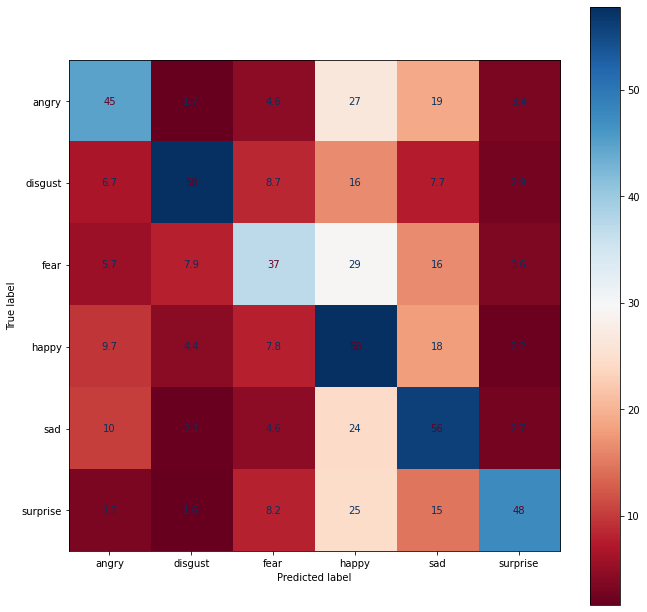

In [23]:
# sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1,figsize=(11,11))

cat_dict = dict( enumerate(dataset['Feeling'].cat.categories ) )

y_pred_cats = [cat_dict[i] for i in y_pred.numpy().tolist()]
y_true_cats = [cat_dict[i] for i in y_true.numpy().tolist()]

matriz_de_confusao = 100*confusion_matrix(y_pred_cats, y_true_cats, normalize='true', labels=list(cat_dict.values()))
# normalize{‘true’, ‘pred’, ‘all’}, default=None
# Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.

#criando list com as emoções
emotion_class = ['Angry','Disgust','Fear','Happy','Sad','Surprise']

df_matriz_de_confusao = pd.DataFrame(matriz_de_confusao, emotion_class, emotion_class)

cfm = ConfusionMatrixDisplay(matriz_de_confusao)

cfm.plot(ax=ax, cmap='RdBu')

ax.set_xticklabels(labels=list(cat_dict.values()))
ax.set_yticklabels(labels=list(cat_dict.values()))

ax.grid(False)

In [24]:
matriz_de_confusao

array([[44.7257384 ,  1.68776371,  4.64135021, 26.58227848, 18.98734177,
         3.37552743],
       [ 6.73076923, 57.69230769,  8.65384615, 16.34615385,  7.69230769,
         2.88461538],
       [ 5.71428571,  7.85714286, 37.14285714, 29.28571429, 16.42857143,
         3.57142857],
       [ 9.67007964,  4.43686007,  7.84982935, 57.79294653, 18.0887372 ,
         2.16154721],
       [10.2915952 ,  2.05831904,  4.63121784, 24.3567753 , 55.91766724,
         2.74442539],
       [ 3.27868852,  1.63934426,  8.19672131, 24.59016393, 14.75409836,
        47.54098361]])

### Gráfico de *loss* e *accuracy*

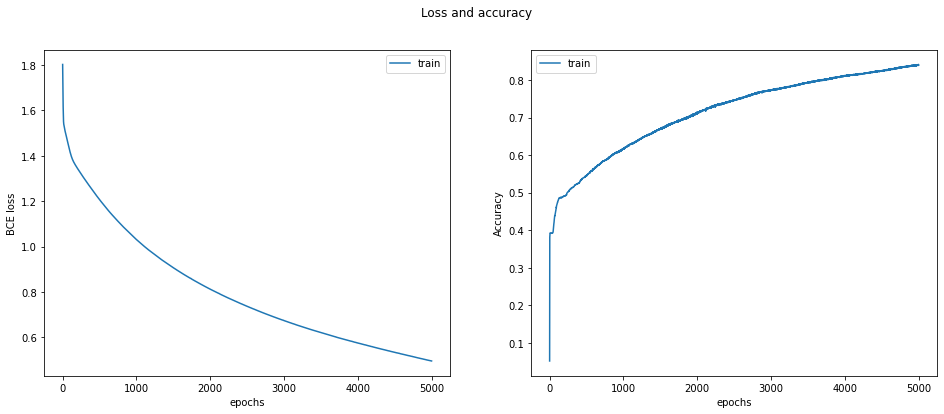

In [25]:
plot_loss_and_accuracy(losses, accs)

#### Salvando o modelo

In [26]:
torch.save(Model, cwd+"/../../models/emotions_classifier.pth")

#### Salvando o dict

In [27]:
torch.save(Model.state_dict(), cwd+"/../../dicts/emotions_classifier_dict")

In [28]:
model = torch.load(cwd+"/../../models/emotions_classifier.pth")
model.eval()

moodClassifier(
  (embedding): Sequential(
    (0): Torch_Mean_Layer()
  )
  (ann): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)